In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [29]:
spark = SparkSession.builder.getOrCreate()

In [30]:
MsVictim = spark.read.csv("MsVictim.csv", header=True, inferSchema=True)
MsPoliceOffice = spark.read.csv("MsPoliceOffice.csv", header=True, inferSchema=True)
MsPolice = spark.read.csv("MsPolice.csv", header=True, inferSchema=True)
MsCaseType = spark.read.csv("MsCaseType.csv", header=True, inferSchema=True)
CaseHeader = spark.read.csv("CaseHeader.csv", header=True, inferSchema=True)
CaseDetail = spark.read.csv("CaseDetail.csv", header=True, inferSchema=True)

In [31]:
MsVictim.registerTempTable("MsVictim")
MsPoliceOffice.registerTempTable("MsPoliceOffice")
MsPolice.registerTempTable("MsPolice")
MsCaseType.registerTempTable("MsCaseType")
CaseHeader.registerTempTable("CaseHeader")
CaseDetail.registerTempTable("CaseDetail")

In [34]:
MsPoliceOffice.show()

+--------------+------------------+
|PoliceOfficeID|PoliceOfficeRegion|
+--------------+------------------+
|             1|          New York|
|             2|        California|
|             3|          Michigan|
|             4|            Oregon|
|             5|          Kentucky|
|             6|              Ohio|
|             7|            Nevada|
|             8|          Colorado|
|             9|           Alabama|
|            10|          Lousiana|
|            11|           Florida|
|            12|        New Jersey|
|            13|        New Mexico|
|            14|          Missouri|
|            15|             Texas|
|            16|           Arizona|
|            17|        Washington|
|            18|            Kansas|
|            19|          Nebraska|
|            20|         Wisconsin|
+--------------+------------------+



In [48]:
result = spark.sql("""

    SELECT 
    
    PoliceOfficeRegion,
    COUNT(ch.CaseID) as `Total Cases`
    
    FROM CaseHeader ch 
    JOIN CaseDetail cd 
    ON ch.CaseID = cd.CaseID
    JOIN MsPolice as mp 
    ON cd.PoliceID = mp.PoliceID
    JOIN MsPoliceOffice mpo
    ON mp.PoliceOfficeID = mpo.PoliceOfficeID
    WHERE CaseStatus = "On Going"
    GROUP BY PoliceOfficeRegion
    ORDER BY `Total Cases` DESC
    LIMIT 5
    


""")

result.show()

+------------------+-----------+
|PoliceOfficeRegion|Total Cases|
+------------------+-----------+
|        California|         30|
|           Florida|         28|
|           Arizona|         28|
|          Nebraska|         28|
|            Oregon|         23|
+------------------+-----------+



In [49]:
import matplotlib.pyplot as plt

In [50]:
df_result = result.toPandas()

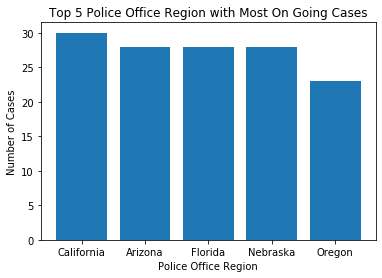

In [59]:
plt.title("Top 5 Police Office Region with Most On Going Cases")
plt.xlabel("Police Office Region")
plt.ylabel("Number of Cases")
plt.bar(df_result["PoliceOfficeRegion"], df_result["Total Cases"])

plt.show()

In [83]:
result = spark.sql("""

    SELECT 
    
    YEAR(CaseDate) as `Case Year`,
    COUNT(VictimID) as `Total Victims`
    
    FROM MsVictim mv
    JOIN CaseHeader ch
    ON mv.CaseID = ch.CaseID
    JOIN CaseDetail cd
    ON ch.CaseID = cd.CaseID
    JOIN MsPolice mp
    ON cd.PoliceID = mp.PoliceID
    JOIN MsPoliceOffice mpo
    ON mp.PoliceOfficeID = mpo.PoliceOfficeID
    WHERE PoliceOfficeRegion in ("Nevada", "Washington", "Oregon", "California")
    GROUP BY `Case Year`
    

""")

result.show()

+---------+-------------+
|Case Year|Total Victims|
+---------+-------------+
|     2018|           56|
|     2019|           41|
|     2020|           74|
|     2021|           61|
+---------+-------------+



In [84]:
df_result = result.toPandas()

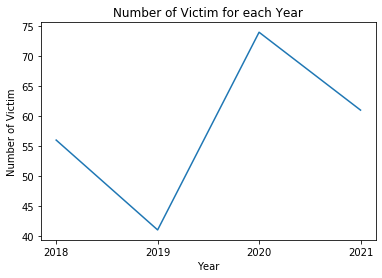

In [88]:
plt.title("Number of Victim for each Year")
plt.ylabel("Number of Victim")
plt.xlabel("Year")
plt.plot(df_result["Case Year"], df_result["Total Victims"])
plt.xticks(df_result["Case Year"])

plt.show()

In [131]:
result = spark.sql("""

    SELECT 
    
    `Crime Type`,
    `Total Victims`
    
    FROM ( 
    
    SELECT
    
    COUNT(VictimID) as `Total Victims`,
    
    CASE 
        WHEN CaseTypeName IN ("Robbery", "Drug", "Burglary") THEN "Violation"
        WHEN CaseTypeName IN ("Fraud and Scam", "Family Violance", "White-Colar Crime") THEN "Misdemeanors"
        ELSE "Felonies"
    END AS `Crime Type`
    
    FROM MsCaseType mt
    JOIN CaseHeader ch
    ON mt.CaseTypeID = ch.CaseTypeID
    JOIN MsVictim mv
    ON ch.CaseID = mv.CaseID
    GROUP BY `Crime Type`
    
    )AS x
    
    WHERE `Total Victims` > 50
    

""")

result.show()



+------------+-------------+
|  Crime Type|Total Victims|
+------------+-------------+
|Misdemeanors|           98|
|   Violation|          133|
|    Felonies|          269|
+------------+-------------+



In [132]:
df_result = result.toPandas()

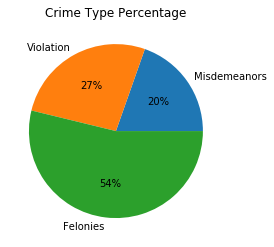

In [133]:
plt.title("Crime Type Percentage")
plt.pie(df_result["Total Victims"], labels=df_result["Crime Type"], autopct="%1.f%%")
plt.show()